In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import warnings

# Set professional plot style
sns.set_theme(style="whitegrid")
warnings.filterwarnings("ignore", category=UserWarning)

print("Libraries imported successfully.")
print("Ready to build the Performance Engine!")

Libraries imported successfully.
Ready to build the Performance Engine!


In [4]:
# --- Database Connection Configuration ---
config = {
    'host': '127.0.0.1',
    'user': 'root',
    'password': 'root',
    'database': 'spherych_devapp'
}

# --- Load the same comprehensive dataset from yesterday ---
query = """
SELECT
    w.id AS workout_id,
    w.score,
    w.completedWorkout,
    w.measuredDuration AS duration,
    rc.difficulty,
    u.id AS userId,
    u.username,
    hd.dob,
    hd.weight,
    hd.height
FROM
    RaceConfigs rc
JOIN
    Workouts w ON rc.workoutId = w.id
JOIN
    Users u ON w.userId = u.id
LEFT JOIN
    HealthData hd ON u.id = hd.userId
"""

df = None
try:
    print("Loading Racer data...")
    conn = mysql.connector.connect(**config)
    df = pd.read_sql(query, conn)
    print(f"Successfully loaded {len(df)} records.")
except Exception as e:
    print(f"Error: {e}")
finally:
    if 'conn' in locals() and conn.is_connected():
        conn.close()

# Apply the same cleaning and feature engineering from yesterday
if df is not None:
    # Clean the data
    df_cleaned = df[(df['score'] > 0) & (df['completedWorkout'] == 1)].copy()
    
    # Calculate age from dob
    dob_datetime = pd.to_datetime(df_cleaned['dob'], errors='coerce')
    df_cleaned['age'] = (pd.to_datetime('today') - dob_datetime).dt.days / 365.25
    df_cleaned = df_cleaned.drop(columns=['dob'])
    
    print(f"Cleaned dataset: {len(df_cleaned)} records ready for modeling.")
    display(df_cleaned.head())

Loading Racer data...
Successfully loaded 15616 records.
Cleaned dataset: 11448 records ready for modeling.


,workout_id,score,completedWorkout,duration,difficulty,userId,username,weight,height,age
0,13,37600,1,299.1150,2,2,Sörde Tschänig,70.0,180.0,37.859001
1,14,29710,1,214.7410,2,2,Sörde Tschänig,70.0,180.0,37.859001
2,15,400,1,22.8907,2,2,Sörde Tschänig,70.0,180.0,37.859001
3,18,950,1,26.9227,2,2,Sörde Tschänig,70.0,180.0,37.859001
4,19,700,1,26.9653,2,2,Sörde Tschänig,70.0,180.0,37.859001


--- Difficulty Level Analysis ---
Records per difficulty level:
difficulty
-1    4318
 0     870
 1     913
 2    5347
Name: count, dtype: int64


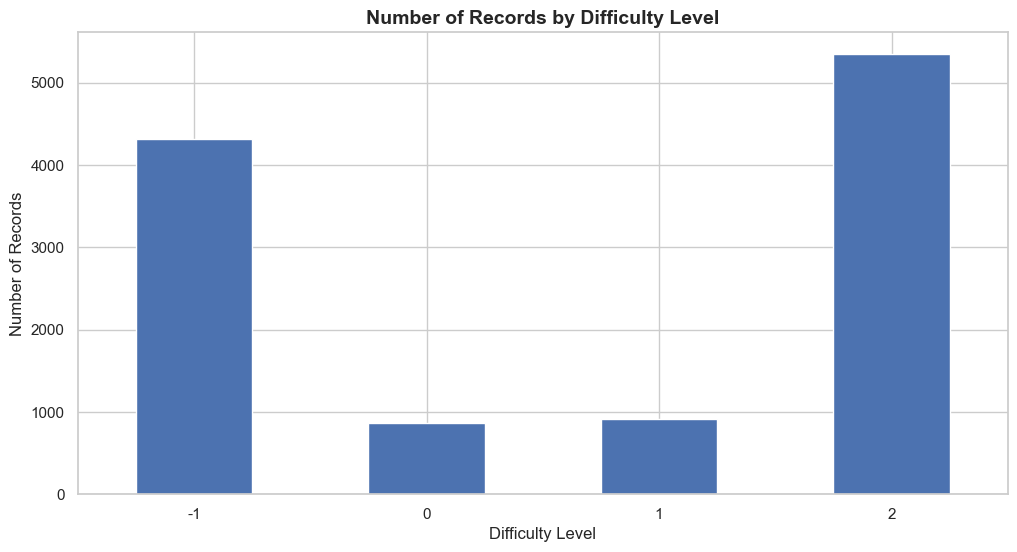


--- Score Statistics by Difficulty ---


,count,mean,std,min,25%,50%,75%,max
difficulty,,,,,,,,
-1,4318.0,203549.602825,183722.413662,60.0,65369.75,161701.5,289216.25,1281800.0
0,870.0,98741.111494,116627.656687,700.0,24762.50,56550.0,128837.50,816400.0
1,913.0,100306.430449,110267.571266,50.0,24235.00,62100.0,135698.00,950350.0
2,5347.0,217004.426781,219690.780812,1.0,63460.00,139680.0,326340.00,1395700.0


In [5]:
if 'df_cleaned' in locals():
    print("--- Difficulty Level Analysis ---")
    difficulty_counts = df_cleaned['difficulty'].value_counts().sort_index()
    print("Records per difficulty level:")
    print(difficulty_counts)
    
    # Visualize the distribution
    plt.figure(figsize=(12, 6))
    difficulty_counts.plot(kind='bar')
    plt.title('Number of Records by Difficulty Level', fontsize=14, weight='bold')
    plt.xlabel('Difficulty Level')
    plt.ylabel('Number of Records')
    plt.xticks(rotation=0)
    plt.show()
    
    # Show some basic stats for each difficulty
    print("\n--- Score Statistics by Difficulty ---")
    difficulty_stats = df_cleaned.groupby('difficulty')['score'].describe()
    display(difficulty_stats)